<a href="https://colab.research.google.com/github/park-geun-hyeong/TimeSeries/blob/main/Basic_Statistical/Box_Jenkins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install pmdarima

In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-whitegrid')

import os
import glob

import statsmodels.api as sm
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import itertools


In [5]:
path = '/content/drive/MyDrive/TimeSeries/1week/'
os.chdir(path)

## None Stational data

In [9]:
data =  pd.read_csv("AirPassengers.csv")
data

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [14]:
data = data.rename(columns = {"Month":'month', '#Passengers':'passengers'})
data['month'] = pd.to_datetime(data['month'])
data = data.set_index('month')
data

,passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


<Figure size 576x432 with 0 Axes>

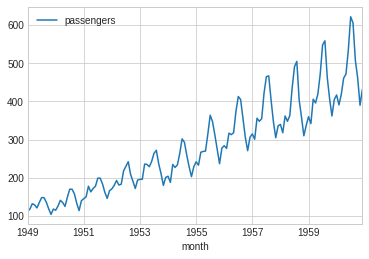

In [16]:
data.plot()

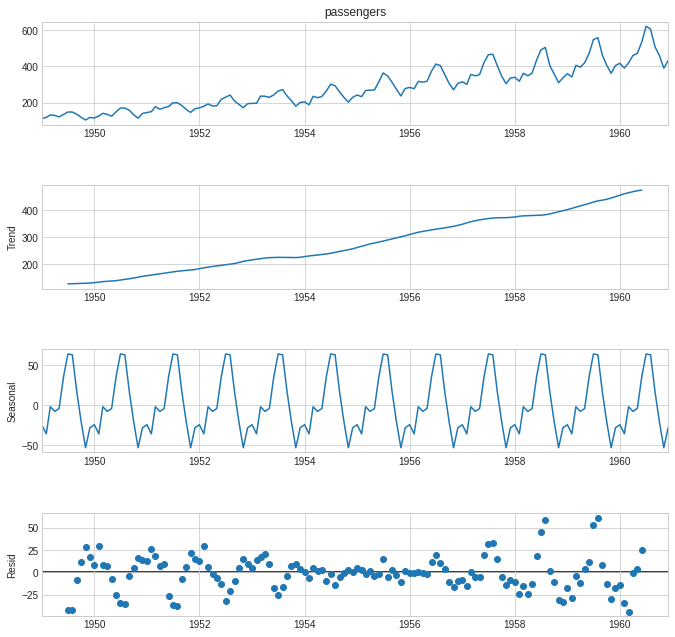

In [18]:
decomposition = sm.tsa.seasonal_decompose(data.passengers, model = 'addictive') # plus model
fig = decomposition.plot()
fig.set_size_inches(10,10)
plt.show()

## Detrend 

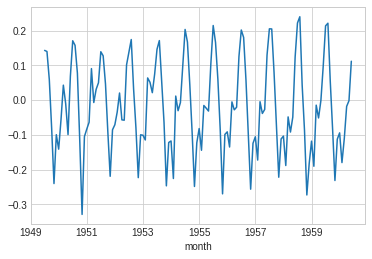

In [21]:
((data.passengers - decomposition.trend) / data.passengers).plot() # Normalization 

## Desesonal

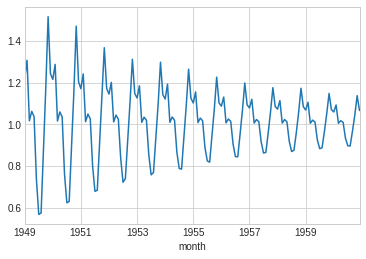

In [96]:
((data.passengers - decomposition.seasonal) / data.passengers).plot() # Normalization 

In [27]:
log_data = np.log(data.copy())

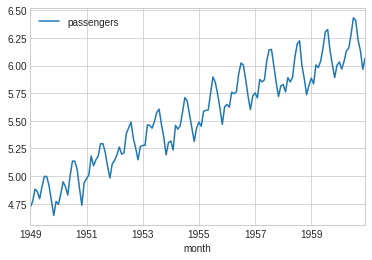

In [28]:
log_data.plot()

In [30]:
train_data, test_data = train_test_split(data, test_size=0.2, shuffle = False) # None shuffle

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


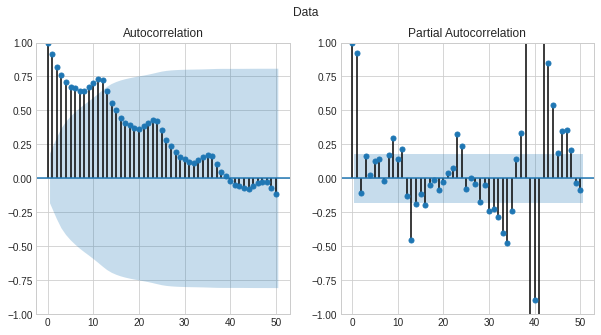

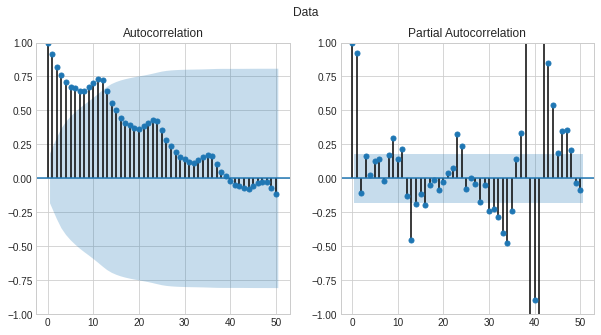

In [31]:
fig, ax = plt.subplots(1,2 , figsize=(10,5))
fig.suptitle('Data')

sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags=50, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags=50, ax=ax[1])

- acf 값이 천천히 0에 수렴한다

## To staitonal data 
- log scailing
- differencing

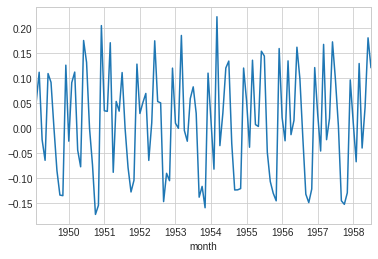

In [33]:
log_train_data =np.log(train_data.copy())
log_test_data = np.log(test_data.copy())

diff_train_data = log_train_data.passengers.diff() #x(t) - x(t-1)
diff_test_data = log_test_data.passengers.diff()
diff_train_data.dropna(inplace=True)

diff_train_data.plot()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


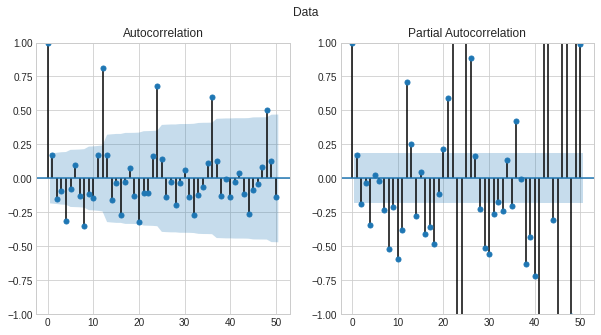

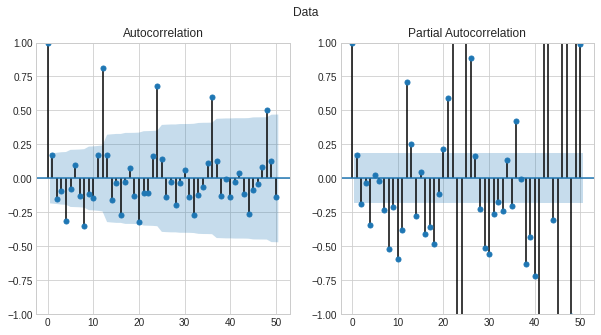

In [34]:
fig, ax = plt.subplots(1,2 , figsize=(10,5))
fig.suptitle('Data')

sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=50, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=50, ax=ax[1])

- acf 값이 빠르게 0에 수렴한다

## Modeling

In [37]:
model = ARIMA(log_train_data.values, order = (1,0,0)) # AR(1), order==> p,d,q
history = model.fit()
history.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  115
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  95.552
Date:                Thu, 30 Dec 2021   AIC                           -185.104
Time:                        13:04:21   BIC                           -176.869
Sample:                             0   HQIC                          -181.762
                                - 115                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.4305      0.322     16.881      0.000       4.800       6.061
ar.L1          0.9791      0.024     40.210      0.000       0.931       1.027
sigma2         0.0108      0.002      5.147      0.000       0.007       0.015
===================================================================================
Ljung-Box (L1) (Q):                   3.31   Jarque-Bera (JB):                 5.71
Prob(Q):                              0.07   Prob(JB):                         0.06
Heteroskedasticity (H):               1.18   Skew:                             0.02
Prob(H) (two-sided):                  0.61   Kurtosis:                         1.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Parameter Tuning

In [97]:
p = range(0,3)
d = range(0,2)
q = range(0,3)

pdq = list(itertools.product(p,d,q))

AIC = []
for i in pdq:
    model = ARIMA(log_train_data.values, order= (i))
    model_fit = model.fit()
    AIC.append(model_fit.aic)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [98]:
optimal =  [(pdq[idx], i) for idx, i in enumerate(AIC) if i == min(AIC)]
optimal

[((1, 1, 2), -199.93967530248176)]

In [99]:
model = ARIMA(diff_train_data.values, order = optimal[0][0]) # AR(1), order==> p,d,q
opt_model_fit = model.fit()

## Prediction

In [100]:
pred = opt_model_fit.forecast(len(log_test_data))
pred

array([0.02934893, 0.00376265, 0.01850589, 0.01001059, 0.01490573,
       0.01208507, 0.01371038, 0.01277385, 0.01331349, 0.01300254,
       0.01318172, 0.01307847, 0.01313796, 0.01310368, 0.01312343,
       0.01311205, 0.01311861, 0.01311483, 0.01311701, 0.01311576,
       0.01311648, 0.01311606, 0.0131163 , 0.01311616, 0.01311624,
       0.0131162 , 0.01311622, 0.01311621, 0.01311622])

In [101]:
prediction = np.exp(pred)
pred_idx = list(test_data.index)
r2= r2_score(test_data, prediction)
r2

-31.613054664464194

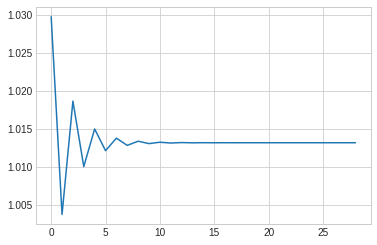

In [103]:
plt.plot(prediction)

In [104]:
opt_model = SARIMAX(log_train_data.values , order = optimal[0][0], seasonal_order =(1,1,2,12))
opt_model_fit = opt_model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [105]:
new_pred = opt_model_fit.get_forecast(len(test_data)) 
new_prediction = np.exp(new_pred.predicted_mean)
new_prediction

array([482.46209718, 423.01731136, 366.42747666, 322.27121118,
       361.93543003, 369.93734252, 352.11819255, 407.57227224,
       396.66067972, 407.29572503, 481.77113628, 538.82122098,
       532.2100719 , 466.02993752, 403.6670657 , 354.82302487,
       398.10325096, 406.50063546, 386.50572534, 446.65064713,
       434.31696153, 446.47529574, 528.52161643, 591.57041222,
       583.9198189 , 511.45813076, 443.07416143, 389.5100254 ,
       437.19567829])

0.9482110584767232

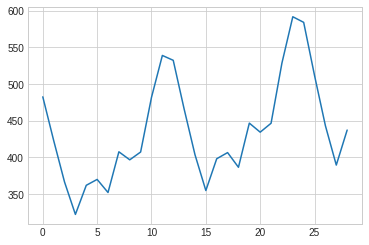

In [120]:
plt.plot(new_prediction)
r2_score(new_prediction, test_data)

In [112]:
auto_arima_model = auto_arima(log_train_data, start_p = 1, start_q= 1, 
                              max_p = 3, max_q= 3, m=12, seasonal=True, 
                              d=1, D=1,
                              max_P=3,maxQ=3,
                              trace= True,
                              error_action='ignore')

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-368.057, Time=3.16 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-335.753, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-365.459, Time=0.73 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-372.171, Time=2.18 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-345.397, Time=0.25 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-370.441, Time=1.63 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-370.509, Time=1.81 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-366.182, Time=0.96 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-368.343, Time=4.66 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-364.570, Time=0.54 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-369.862, Time=2.39 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-370.241, Time=1.81 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-371.865, Time=1.02 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-368.302, Time=2.97 sec
 ARIMA(0,1,1)(0,1,1

## ADF

In [114]:
from statsmodels.tsa.stattools import adfuller

In [117]:
result = adfuller(train_data)
print(f"ADF Statistic: {result[0]:.6f}")
print(f"p value: {result[1]:.6f}")
print('Critical values: ')
for k, v in result[4].items():
    print('\t%s: %.3f' %(k,v))

ADF Statistic: -0.356889
p value: 0.917052
Critical values: 
	1%: -3.497
	5%: -2.891
	10%: -2.582


In [119]:
result = adfuller(log_train_data)
print(f"ADF Statistic: {result[0]:.6f}")
print(f"p value: {result[1]:.6f}")
print('Critical values: ')
for k, v in result[4].items():
    print('\t%s: %.3f' %(k,v))

ADF Statistic: -1.574027
p value: 0.496626
Critical values: 
	1%: -3.497
	5%: -2.891
	10%: -2.582


In [118]:
result = adfuller(diff_train_data)
print(f"ADF Statistic: {result[0]:.6f}")
print(f"p value: {result[1]:.6f}")
print('Critical values: ')
for k, v in result[4].items():
    print('\t%s: %.3f' %(k,v))

ADF Statistic: -2.635851
p value: 0.085812
Critical values: 
	1%: -3.497
	5%: -2.891
	10%: -2.582
